In [1]:
import os
from pathlib import Path
import pandas as pd
import pycaret
from pycaret.regression import setup, compare_models, finalize_model, plot_model, save_model, predict_model

# pycaret.show_versions()


In [2]:
# odczytujemy plik cleaned.csv zapisany w csv_processing.ipynb

LOCAL_DATA_PROC = Path('data') / 'proc'

cleaned_csv = 'time_sec_cleaned.csv'

df = pd.read_csv(LOCAL_DATA_PROC / cleaned_csv, sep=";")
df

,5_km_sec,finish_sec,age,gender
0,1030,4456,22,M
1,1013,4462,31,M
2,1029,4483,26,M
3,1035,4490,31,M
4,1035,4496,27,M
...,...,...,...,...
17979,1812,10483,36,M
17980,2139,10483,26,F
17981,2197,10486,54,M
17982,2197,10486,29,M


In [3]:
ESTIMATOR = "MAE"
# tworzę eksperyment
# najlepszy model powstaje, gdy podane są wszystkie czasy pośrednie (5 km, 10 km, 15 km, 20 km)
# ignorowanie każdego kolejnego zwiększa MAE od 36 do 285
# i nawet pozostawienie tylko czasu na 5 km daje dobrą predykcję, ale dziwi mnie wtedy plot_model,
# który pokazuje, że najważniejszą cechą jest wtedy gender ?
# nie potwierdza się to też w testach, gdzie gender nie ma znaczenia

exp = setup(
    data=df, 
    target='finish_sec',
    session_id=123)

,Description,Value
0,Session id,123
1,Target,finish_sec
2,Target type,Regression
3,Original data shape,"(17984, 4)"
4,Transformed data shape,"(17984, 4)"
5,Transformed train set shape,"(12588, 4)"
6,Transformed test set shape,"(5396, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [4]:
exp.dataset_transformed.sample(10)

,5_km_sec,age,gender,finish_sec
17382,2117.0,34.0,1.0,9316
9364,1444.0,42.0,1.0,6198
1643,1438.0,37.0,0.0,6353
11615,1678.0,33.0,1.0,6945
3590,1568.0,36.0,1.0,7071
17454,2017.0,31.0,0.0,9399
49,1103.0,40.0,1.0,4878
16145,2055.0,29.0,1.0,8448
15733,2111.0,43.0,0.0,8256
16002,1842.0,43.0,1.0,8382


In [5]:
# szukam najlepszego modelu pod katem metryki MAE - średni bład bezw.

best_models = exp.compare_models(sort=ESTIMATOR)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,291.4043,164384.6243,405.0782,0.8738,0.0518,0.0381,0.0110
lasso,Lasso Regression,294.5147,160782.7016,400.6467,0.8765,0.0515,0.0388,0.0900
llar,Lasso Least Angle Regression,294.5147,160782.7018,400.6467,0.8765,0.0515,0.0388,0.0060
en,Elastic Net,294.5173,160784.0269,400.6484,0.8765,0.0515,0.0388,0.0070
br,Bayesian Ridge,294.5190,160784.9315,400.6496,0.8765,0.0515,0.0388,0.0060
lr,Linear Regression,294.5556,160805.6082,400.6754,0.8765,0.0515,0.0388,0.1660
lar,Least Angle Regression,294.5556,160805.6082,400.6754,0.8765,0.0515,0.0388,0.0060
ridge,Ridge Regression,294.5556,160805.5960,400.6754,0.8765,0.0515,0.0388,0.0070
omp,Orthogonal Matching Pursuit,294.7130,161008.3102,400.9378,0.8764,0.0515,0.0388,0.0060
gbr,Gradient Boosting Regressor,295.3007,162049.2761,402.1878,0.8756,0.0516,0.0389,0.0540


In [6]:
# próba strojenia hiperparametrów

best_tuned_model = exp.tune_model(best_models, n_iter=5, optimize=ESTIMATOR)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,300.2920,173641.3104,416.7029,0.8656,0.0537,0.0392
1,283.1045,164465.4918,405.5435,0.8695,0.0513,0.0370
2,284.8161,161888.9507,402.3543,0.8695,0.0507,0.0369
3,279.1286,142924.4679,378.0535,0.8835,0.0486,0.0368
4,296.0999,173919.4959,417.0366,0.8752,0.0533,0.0386
5,281.0591,149106.0639,386.1425,0.8836,0.0496,0.0370
6,312.3830,199708.3114,446.8874,0.8508,0.0563,0.0399
7,290.3822,167520.4931,409.2927,0.8741,0.0517,0.0378
8,287.2837,165109.7450,406.3370,0.8740,0.0524,0.0374


Fitting 10 folds for each of 5 candidates, totalling 50 fits


In [7]:
# strojenie hiperparametrow nie przynioslo rezultatow

best_model = compare_models([best_models, best_tuned_model])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Huber Regressor,291.4043,164384.6243,405.0782,0.8738,0.0518,0.0381,0.0110
1,Huber Regressor,290.8597,166580.7620,407.7646,0.8721,0.0521,0.0379,0.0100


In [8]:
# sprawdzam best model na Holdout Dataset - jeszcze lepsza skuteczność!

exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,288.1997,160712.0311,400.8891,0.8752,0.0511,0.0376


,5_km_sec,age,gender,finish_sec,prediction_label
10136,1542,27,M,6487,6717.256379
1899,1482,44,M,6460,6484.619180
6850,1990,37,F,8665,8772.752678
13779,1682,38,M,7548,7371.139814
8885,1414,49,M,5954,6189.690599
...,...,...,...,...,...
3435,1584,37,F,7025,6946.416756
5739,1862,40,M,7919,8185.229473
5587,1644,56,M,7834,7239.658669
14917,1769,40,M,7914,7766.881590


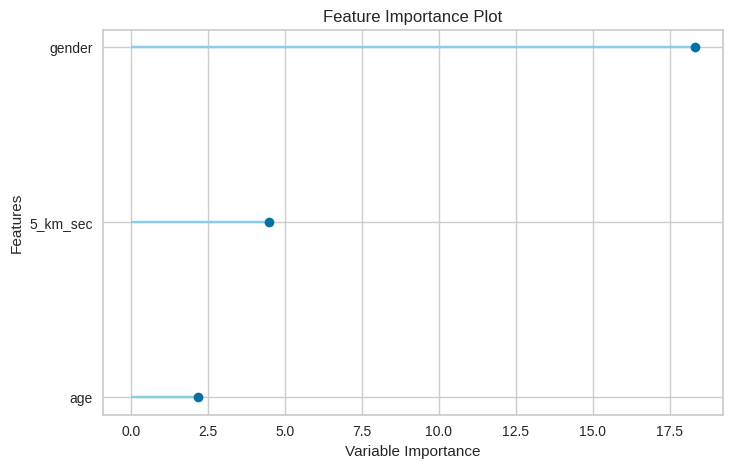

In [9]:
# istotność cech

# już nie mam na niego siły, ciągle pokazuje Płeć jako najważniejszą cechę

plot_model(best_model, plot='feature')

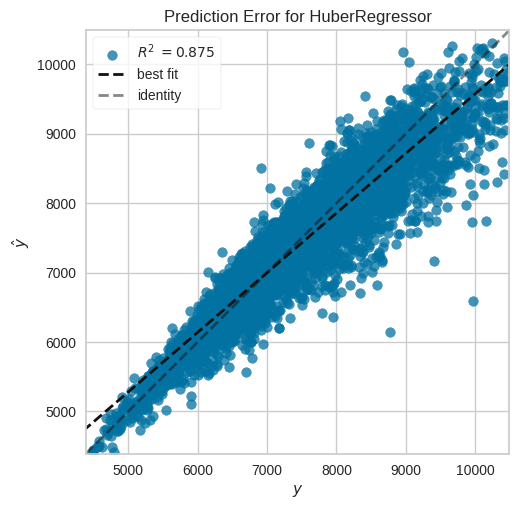

In [10]:
plot_model(best_model, plot='error')

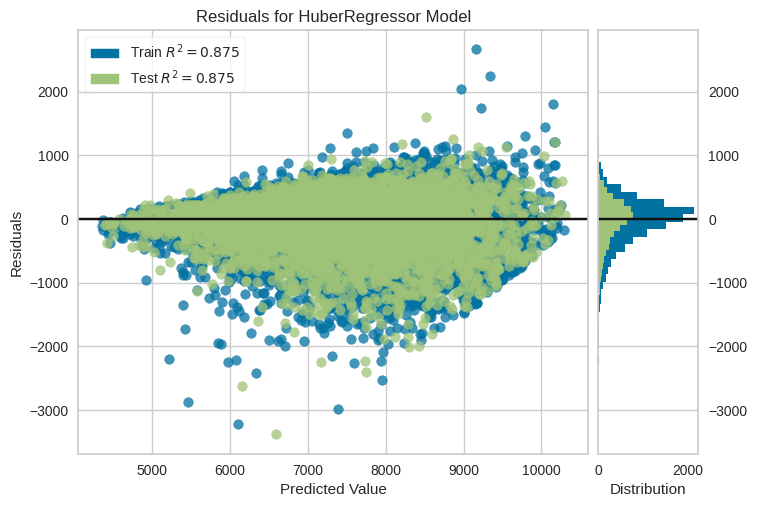

In [11]:
plot_model(best_model, plot='residuals')

In [12]:
final_model = finalize_model(best_model)
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['5_km_sec', 'age'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['gender'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['gender'],
                                    transformer=OrdinalEncoder(cols=['gender'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'gender',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': F      0
M      1
NaN   -1
dtype: int64}]))),
                ('actual_estimator', HuberRegressor())])

In [14]:
# zapisuję pipeline lokalnie

LOCAL_DATA_MODELS = Path('data') / 'models'
model = 'time_sec_model'

os.makedirs(LOCAL_DATA_MODELS, exist_ok=True)
save_model(final_model, 'data/models/' + model)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5_km_sec', 'age'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['gender'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['gender'],
                                     transformer=OrdinalEncoder(cols=['gender'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'gender',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': F      0
 M      1
 NaN   -1
 dtype: int64}]))),
    

In [15]:
# klient do Digital Ocean

import boto3

s3 = boto3.client("s3")

BUCKET_NAME = "wk1"
REMOTE_DATA = 'zadanie_9/'

In [16]:
# zapisuję model do Digital Ocean

model_pkl = model + '.pkl'

s3.upload_file(Filename=LOCAL_DATA_MODELS / model_pkl, Bucket=BUCKET_NAME, Key=REMOTE_DATA + 'models/' + model_pkl)

In [17]:
user_data_df = pd.DataFrame(
        {'age' : 28,
        'gender' : 'M',
        '5_km_sec' : 1600, 
        }, index=[0])

In [18]:
import datetime

prediction = predict_model(final_model, data=user_data_df)

prediction_seconds = round(prediction["prediction_label"][0], 2)

prediction_time = str(datetime.timedelta(seconds=int(prediction_seconds)))

print(f'Estymowany czas ukończenia półmaratonu w formacie: H:M:S wynosi {prediction_time}')

Estymowany czas ukończenia półmaratonu w formacie: H:M:S wynosi 1:56:25
